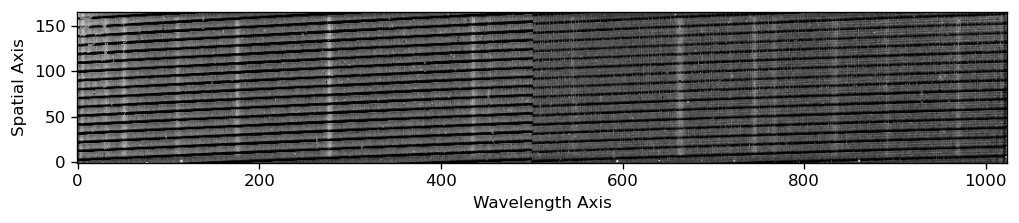

In [2]:
# import packages
from matplotlib import rcParams
rcParams['figure.dpi'] = 120
rcParams["savefig.dpi"] = 200
rcParams['figure.facecolor'] = 'w'

from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from lmfit import Model
from lmfit.models import PolynomialModel, QuadraticModel, LinearModel, ConstantModel
from lmfit import minimize, Parameters, fit_report

import os
import warnings
warnings.filterwarnings('ignore')

# path joining version for other paths
notebook_path = os.path.abspath('/Users/RuoyanWang/Documents/LEICESTER/h3p/code/')
filepath = os.path.join(os.path.dirname(notebook_path), '02jun17/spec/')

# count number of fits files in folder
filesize = len([name for name in os.listdir(filepath) if os.path.isfile(os.path.join(filepath, name))])


# define normalization function
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# define guassian function, credit to pen and pants IDL's Gaussfit in Python
def gaussian_fit(x, a0, a1, a2, a3, a4, a5): 
    """
    x = data array
    a0 = height of guassian
    a1 = pixel position of Gaussian peak
    a2 = width of Gaussian
    a3 = constant term
    a4 = linear term
    a5 = quadratic term
    
    note: fwhm = a2 * np.sqrt(2 * np.log(2)) * 2
    """
    z = (x - a1) / a2
    y = a0 * np.exp(-z**2 / a2) + a3 + a4 * x + a5 * x**2
    return y

# load waverange
waverange = fits.open(filepath + 'order32/' + 'waverange.fits', ignore_missing_end=True)[0].data

# load skylines
skylines = fits.open(filepath + 'order32/' + 'skylines60m_order32.fits', ignore_missing_end=True)[0].data
# skylines_60p = fits.open(filepath + 'order32/skylines_order32.fits', ignore_missing_end=True)[0].data
# skylines_shifted = fits.open(filepath + 'order32/skylines_shifted_order32.fits', ignore_missing_end=True)[0].data

# spat_lower = 220
# spat_upper = 320

plt.figure(figsize=(10,2))
plt.imshow(skylines, cmap='gist_gray')
# plt.imshow(skylines, aspect='auto', extent=[waverange[0], waverange[-1], 0, 165], cmap='gist_gray')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 1024
    # variables        = 2
    chi-square         = 4.8537e-12
    reduced chi-square = 4.7492e-15
    Akaike info crit   = -33770.3461
    Bayesian info crit = -33760.4832
[[Variables]]
    slope:      3.3040e-05 +/- 7.2853e-12 (0.00%) (init = 3.304e-05)
    intercept:  2.38226635 +/- 4.3040e-09 (0.00%) (init = 2.382266)
[[Correlations]] (unreported correlations are < 0.250)
    C(slope, intercept) = -0.866


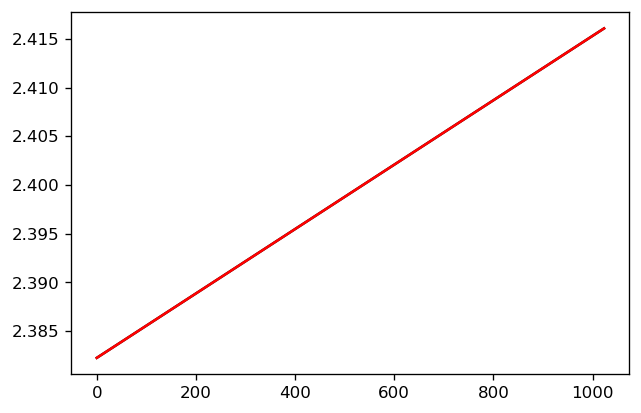

In [3]:
waveaxis = np.linspace(0, 1023, 1024)

mod = LinearModel()

pars = mod.guess(waverange, x=waveaxis)
out = mod.fit(waverange, pars, x=waveaxis)

print(out.fit_report(min_correl=0.25))

slope = out.params['slope'].value
intercept = out.params['intercept'].value

wave_best_fit = slope*waveaxis + intercept

plt.figure()
plt.plot(waveaxis, waverange,'k', label = 'original')
plt.plot(waveaxis, wave_best_fit, 'r', label = 'best fit')

[[Model]]
    Model(gaussian_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 54
    # data points      = 130
    # variables        = 6
    chi-square         = 2653.32095
    reduced chi-square = 21.3977496
    Akaike info crit   = 404.084273
    Bayesian info crit = 421.289480
[[Variables]]
    a0:  76.0346608 +/- 3.14438391 (4.14%) (init = 79)
    a1:  2.38815051 +/- 1.7780e-06 (0.00%) (init = 2.3882)
    a2:  0.00141935 +/- 4.6004e-05 (3.24%) (init = 0.003)
    a3: -6035923.25 +/- 4944758.69 (81.92%) (init = 0)
    a4:  5056687.74 +/- 4140848.85 (81.89%) (init = 0)
    a5: -1059078.68 +/- 866909.221 (81.86%) (init = 0)
[[Correlations]] (unreported correlations are < 0.250)
    C(a4, a5) = -1.000
    C(a3, a4) = -1.000
    C(a3, a5) =  1.000
    C(a0, a2) = -0.514
2.3881505075715364


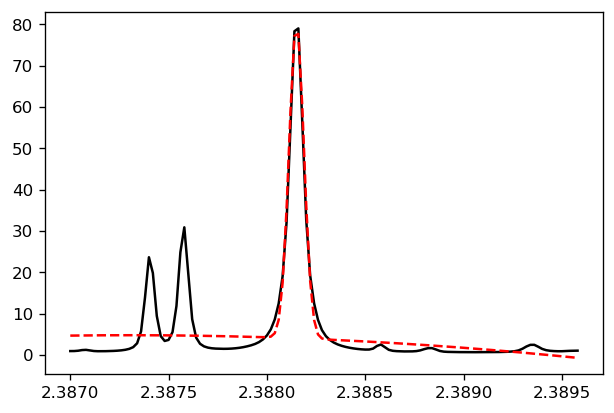

In [3]:
gemini_df = pd.read_csv('mk_skybg_zm_10_10_ph.dat', sep='\s+', header=None)
gemini_array = gemini_df.to_numpy()

wavelength = (gemini_array[74350:74480,0])/1000#[gemini_array[60500:62500,1]>0.5]
count = gemini_array[74350:74480,1]#[gemini_array[60500:62500,1]>0.5]

plt.figure()
plt.plot(wavelength, count, 'k', label='original')

# create lmfit model with defined gaussian
g1_model = Model(gaussian_fit)

# create parameters and add initial guess
g1_params = g1_model.make_params()
g1_params.add('a0', value=79, min=76, max=85)
g1_params.add('a1', value=2.3882)
g1_params.add('a2', value=0.003)
g1_params.add('a3', value=0)
g1_params.add('a4', value=0)
g1_params.add('a5', value=0)

g1_result = g1_model.fit(count, g1_params, x=wavelength)
# try:
#     g1_result = g1_model.fit(count, g1_params, x=wavelength)
# except:
#     pass

print(g1_result.fit_report(min_correl=0.25))

plt.plot(wavelength, g1_result.best_fit, 'r--', label='g1 best fit')
#plt.xlim(2.123,2.1235)

print(g1_result.params['a1'].value)

[[Model]]
    Model(gaussian_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 132
    # data points      = 130
    # variables        = 6
    chi-square         = 9118.41490
    reduced chi-square = 73.5356041
    Akaike info crit   = 564.567186
    Bayesian info crit = 581.772392
[[Variables]]
    a0:  92.0014592 +/- 5.91869140 (6.43%) (init = 97)
    a1:  2.40697765 +/- 2.7597e-06 (0.00%) (init = 2.407)
    a2:  0.00138266 +/- 6.9643e-05 (5.04%) (init = 0.003)
    a3:  112.639608 +/- 1859205.37 (1650578.70%) (init = 0)
    a4:  0.80827335 +/- 1544396.47 (191073535.53%) (init = 0)
    a5: -18.7705181 +/- 320723.218 (1708654.06%) (init = 0)
[[Correlations]] (unreported correlations are < 0.250)
    C(a4, a5) = -1.000
    C(a3, a4) = -1.000
    C(a3, a5) =  1.000
    C(a0, a2) = -0.520
    C(a1, a5) = -0.253
    C(a1, a4) =  0.253
    C(a1, a3) = -0.253
2.406977650214528


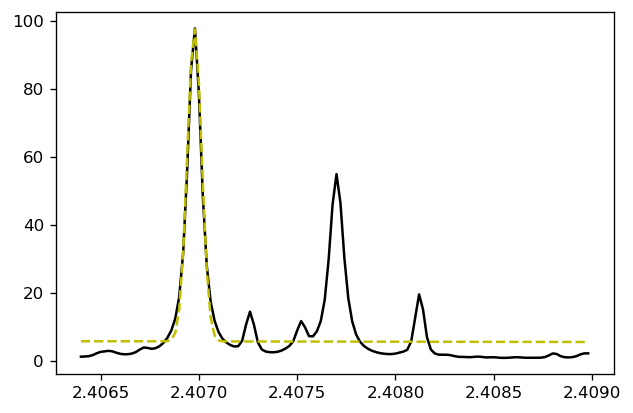

In [4]:
gemini_df = pd.read_csv('mk_skybg_zm_10_10_ph.dat', sep='\s+', header=None)
gemini_array = gemini_df.to_numpy()

wavelength = (gemini_array[75320:75450,0])/1000#[gemini_array[60500:62500,1]>0.5]
count = gemini_array[75320:75450,1]#[gemini_array[60500:62500,1]>0.5]
# count[count<30]=30

plt.figure()
plt.plot(wavelength, count, 'k', label='original')

# create lmfit model with defined gaussian
g2_model = Model(gaussian_fit)
#print('parameter names: {}'.format(g2model.param_names))
#print('independent variables: {}'.format(g2model.independent_vars))


# create parameters and add initial guess
g2_params = g2_model.make_params()
g2_params.add('a0', value=97, min=92)
g2_params.add('a1', value=2.4070)
g2_params.add('a2', value=0.003)
g2_params.add('a3', value=0)
g2_params.add('a4', value=0)
g2_params.add('a5', value=0)

try:
    g2_result = g2_model.fit(count, g2_params, x=wavelength)
except:
    pass

print(g2_result.fit_report(min_correl=0.25))

plt.plot(wavelength, g2_result.best_fit, 'y--', label='g2 best fit')
#plt.xlim(2.1246,2.1252)

print(g2_result.params['a1'].value)

[[Model]]
    Model(gaussian_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 86
    # data points      = 180
    # variables        = 6
    chi-square         = 2563.68286
    reduced chi-square = 14.7338095
    Akaike info crit   = 490.123789
    Bayesian info crit = 509.281530
[[Variables]]
    a0:  99.6555979 +/- 2.46235813 (2.47%) (init = 105)
    a1:  2.41433340 +/- 1.1829e-06 (0.00%) (init = 2.4143)
    a2:  0.00151707 +/- 2.9281e-05 (1.93%) (init = 0.003)
    a3: -4934979.86 +/- 1774154.29 (35.95%) (init = 0)
    a4:  4088576.28 +/- 1470008.56 (35.95%) (init = 0)
    a5: -846834.243 +/- 304500.691 (35.96%) (init = 0)
[[Correlations]] (unreported correlations are < 0.250)
    C(a3, a4) = -1.000
    C(a4, a5) = -1.000
    C(a3, a5) =  1.000
    C(a0, a2) = -0.534
2.414333399305005


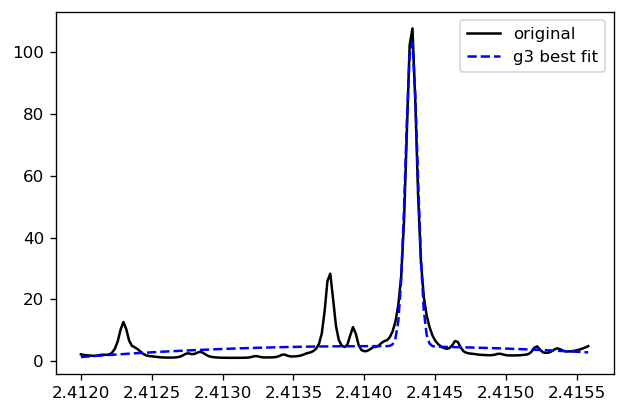

In [5]:
gemini_df = pd.read_csv('mk_skybg_zm_10_10_ph.dat', sep='\s+', header=None)
gemini_array = gemini_df.to_numpy()

wavelength = (gemini_array[75600:75780,0]/1000)#[gemini_array[60500:62500,1]>0.5]
count = gemini_array[75600:75780,1]#[gemini_array[60500:62500,1]>0.5]

plt.figure()
plt.plot(wavelength, count, 'k', label='original')

# create lmfit model with defined gaussian
g3_model = Model(gaussian_fit)

# create parameters and add initial guess
g3_params = g3_model.make_params()
g3_params.add('a0', value=105)
g3_params.add('a1', value=2.4143, min=2.41)
g3_params.add('a2', value=0.003)
g3_params.add('a3', value=0)
g3_params.add('a4', value=0)
g3_params.add('a5', value=0)

try:
    g3_result = g3_model.fit(count, g3_params, x=wavelength)
except:
    pass

print(g3_result.fit_report(min_correl=0.25))

plt.plot(wavelength, g3_result.best_fit, 'b--', label='g3 best fit')
plt.legend()
#plt.xlim(2.1315,2.133)

print(g3_result.params['a1'].value)

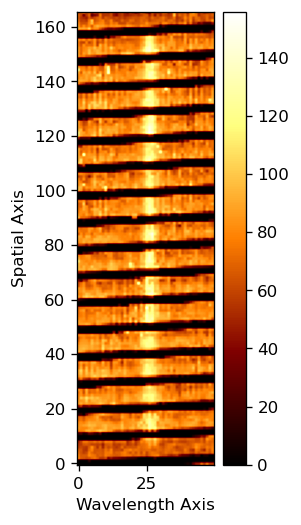

In [6]:
a = np.delete(skylines, np.s_[200:], 1)
b = np.delete(a, np.s_[:150], 1)
# b[b<70]=70
# b[b>120]=120

plt.figure(figsize=(2,5))
# plt.imshow(c, aspect='auto', extent=[waverange[120], waverange[179], 364, 225], cmap='afmhot')
plt.imshow(b, cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()
plt.colorbar()

In [7]:
for i in range(len(b)):
    if i%5 == 0 and i%10 != 0 and i!= 5:
        print ('i = ' +str(i))
#         plt.figure()
#         plt.plot(b[i])
#         plt.title('i = ' +str(i))

i = 15
i = 25
i = 35
i = 45
i = 55
i = 65
i = 75
i = 85
i = 95
i = 105
i = 115
i = 125
i = 135
i = 145
i = 155
i = 165


In [10]:
a = np.delete(skylines, np.s_[200:], 1)
b = np.delete(a, np.s_[:150], 1)
b = normalize(b)
waveaxis = np.linspace(0, np.size(b, 1)-1, np.size(b, 1))
# waveaxis = waverange[150:200]*100000

upper_skyline = 166
lower_skyline = 0

sky1_a1 = []
sky1_a1_pixel = []

for i in range(lower_skyline, upper_skyline):           
    if i%5 == 0 and i%10 != 0 and i!= 5:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=0.7)
#         sky1_params.add('a1', value=238815)
        sky1_params.add('a1', value=25)
        sky1_params.add('a2', value=1)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(b[i], sky1_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, b[i])
            plt.plot(waveaxis, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1.append(sky1_fit_result.params['a1'].value)
# sky1_a1 = np.array(sky1_a1)/100000
sky1_a1 = np.array(sky1_a1)+150

[[Model]]
    Model(constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2
    # data points      = 16
    # variables        = 1
    chi-square         = 1.25421671
    reduced chi-square = 0.08361445
    Akaike info crit   = -38.7372397
    Bayesian info crit = -37.9646509
[[Variables]]
    c:  176.097841 +/- 0.07229041 (0.04%) (init = 176.0978)


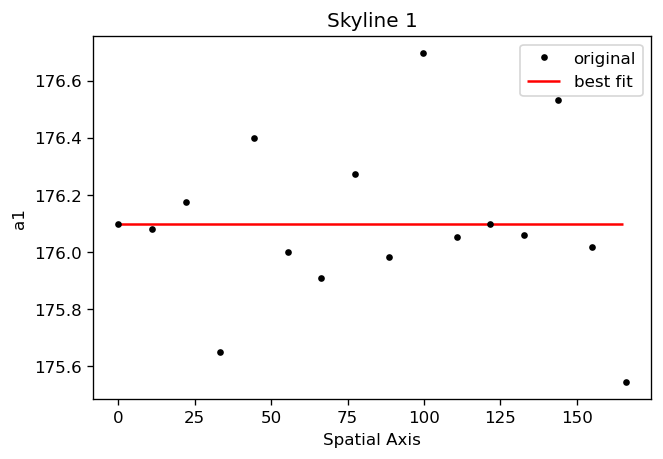

In [12]:
sky1_spat = np.linspace(lower_skyline, upper_skyline, len(sky1_a1))

x = sky1_spat
y = sky1_a1

mod = ConstantModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

sky1_spat_all = np.linspace(0, 165, 166)
# sky1_slope = out.params['slope'].value
# sky1_intercept = out.params['intercept'].value
sky1_c = out.params['c'].value
sky1_a1_best_fit = sky1_c

plt.plot(x, y, '.k', label = 'original')
plt.hlines(sky1_a1_best_fit, xmin=sky1_spat_all[0], xmax=sky1_spat_all[-1], color='r', label='best fit')
# plt.hlines(g1_result.params['a1'].value, xmin=sky1_spat_all[0], xmax=sky1_spat_all[-1], color='b', label='g1')
plt.title('Skyline 1')
plt.xlabel('Spatial Axis')
plt.ylabel('a1')
plt.legend()

[[Model]]
    Model(constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2
    # data points      = 15
    # variables        = 1
    chi-square         = 1.0149e-09
    reduced chi-square = 7.2495e-11
    Akaike info crit   = -349.247456
    Bayesian info crit = -348.539405
[[Variables]]
    c:  2.38808581 +/- 2.1984e-06 (0.00%) (init = 2.388086)


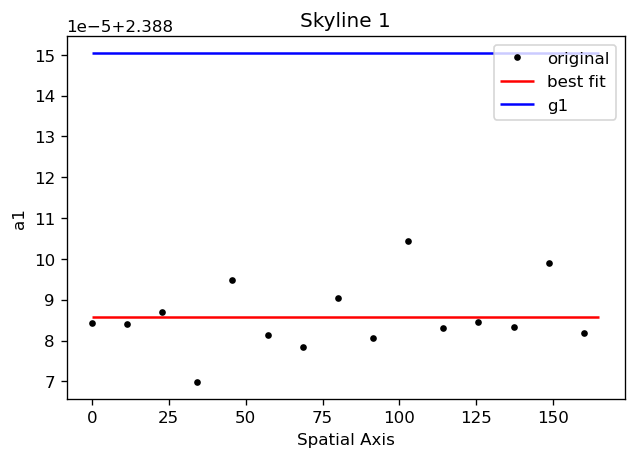

In [93]:
sky1_spat = np.linspace(lower_skyline, upper_skyline, len(sky1_a1))

x = sky1_spat
y = sky1_a1

mod = ConstantModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

sky1_spat_all = np.linspace(0, 165, 166)
# sky1_slope = out.params['slope'].value
# sky1_intercept = out.params['intercept'].value
sky1_c = out.params['c'].value
sky1_a1_best_fit = sky1_c

plt.plot(x, y, '.k', label = 'original')
plt.hlines(sky1_a1_best_fit, xmin=sky1_spat_all[0], xmax=sky1_spat_all[-1], color='r', label='best fit')
plt.hlines(g1_result.params['a1'].value, xmin=sky1_spat_all[0], xmax=sky1_spat_all[-1], color='b', label='g1')
plt.title('Skyline 1')
plt.xlabel('Spatial Axis')
plt.ylabel('a1')
plt.legend()

In [96]:
g1_result.params['a1'].value - sky1_a1_best_fit

6.46977834275475e-05

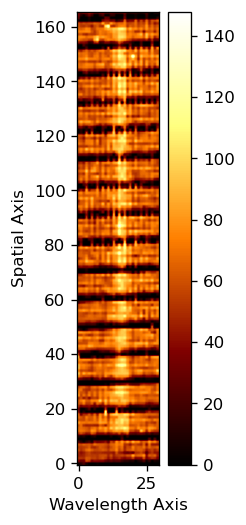

In [147]:
c = np.delete(skylines, np.s_[760:], 1)
d = np.delete(c, np.s_[:730], 1)

plt.figure(figsize=(2,5))
# plt.imshow(c, aspect='auto', extent=[waverange[120], waverange[179], 364, 225], cmap='afmhot')
plt.imshow(d, cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()
plt.colorbar()

i = 15
i = 25
i = 35
i = 45
i = 55
i = 65
i = 75
i = 85
i = 95
i = 105
i = 115
i = 125
i = 135
i = 145
i = 155


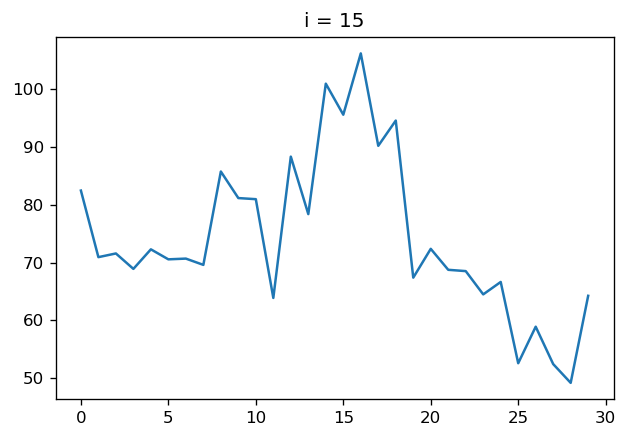

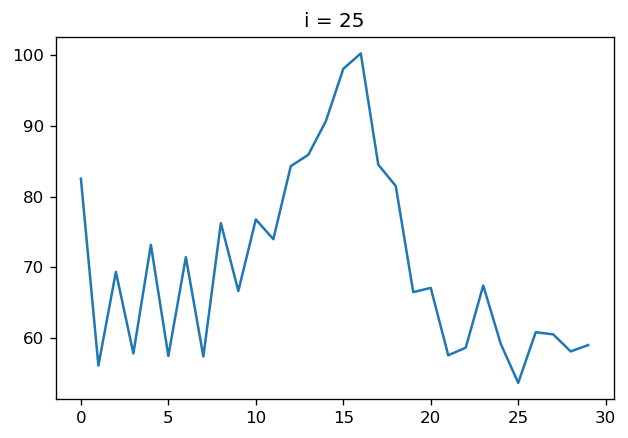

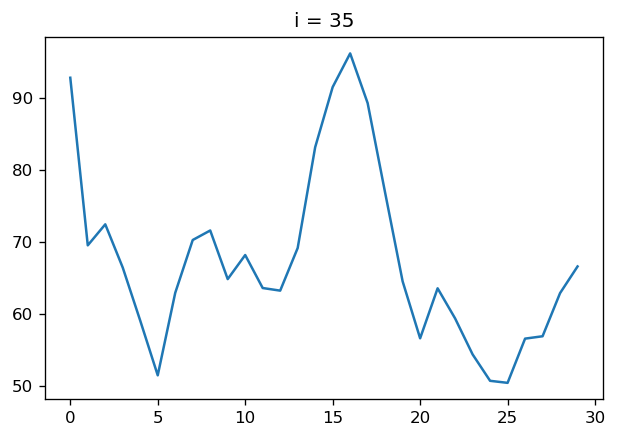

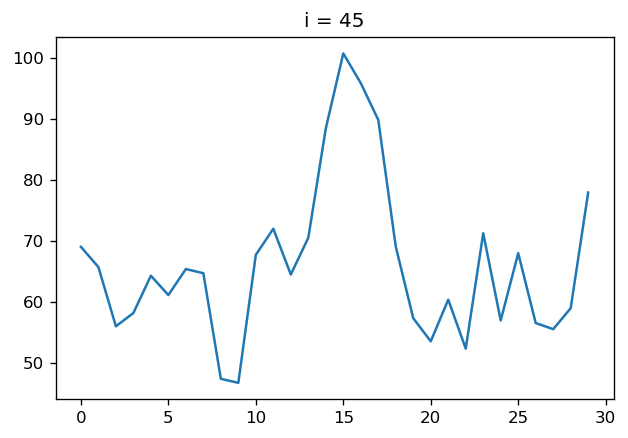

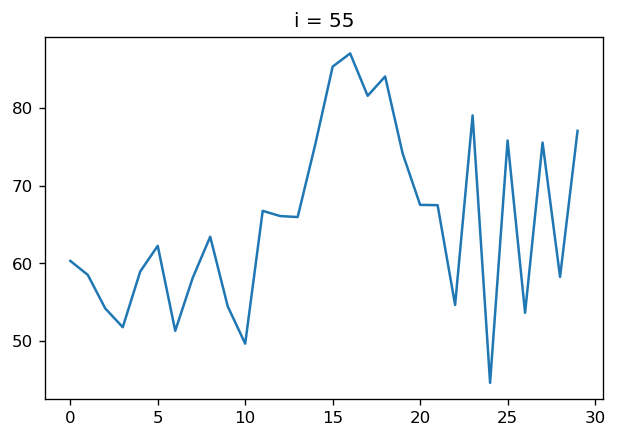

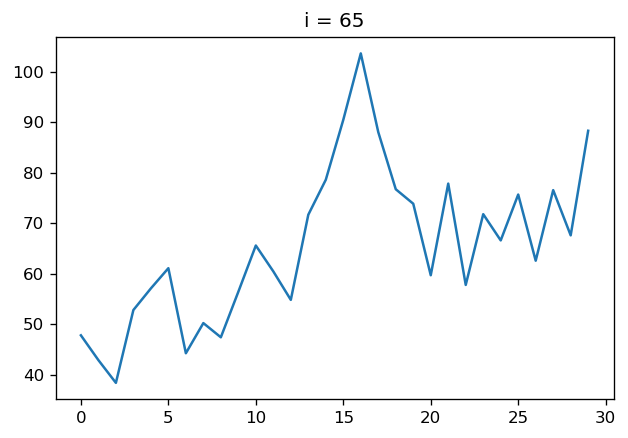

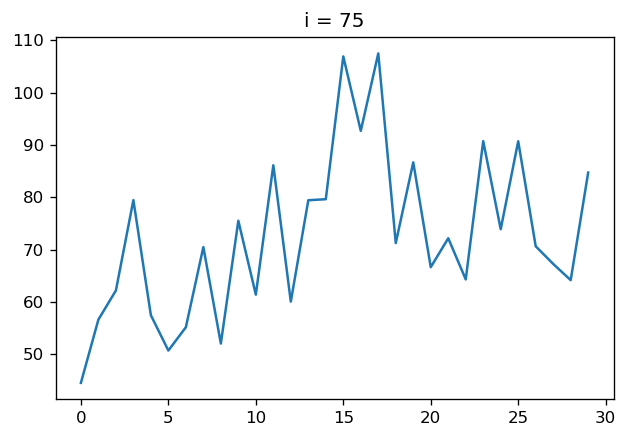

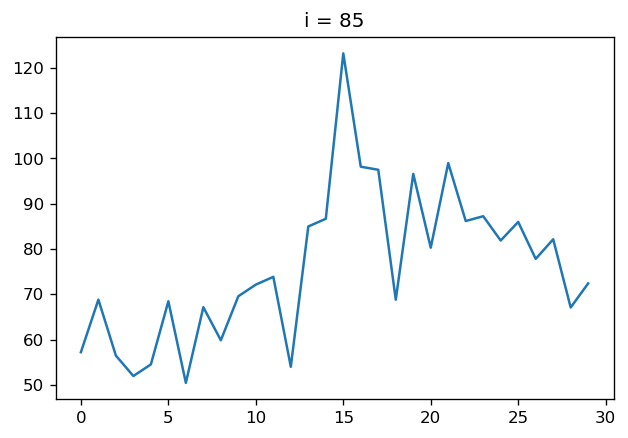

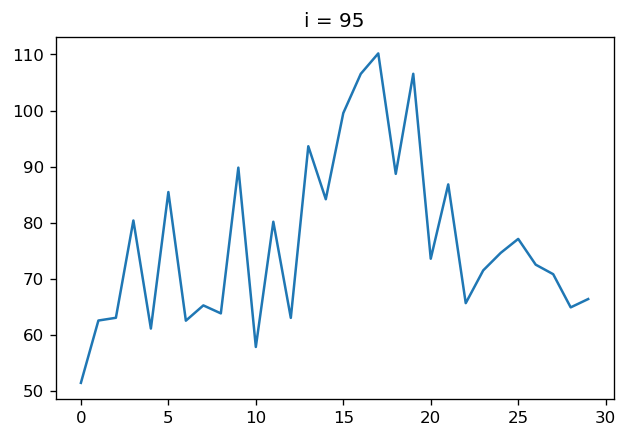

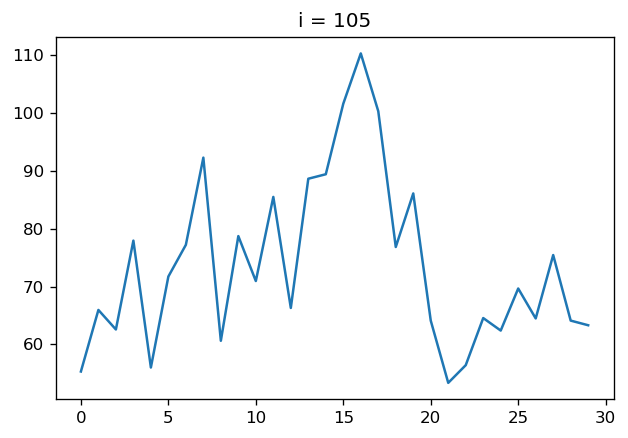

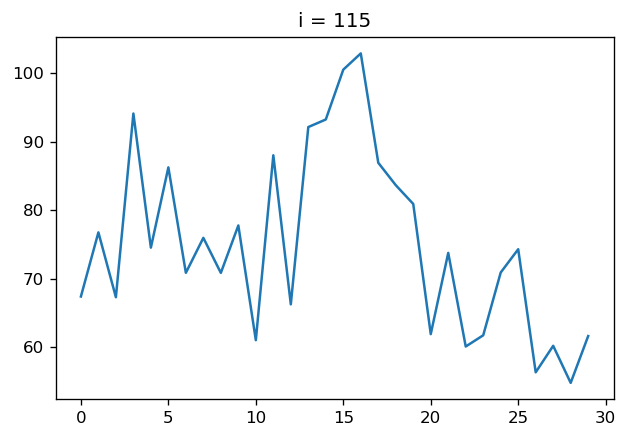

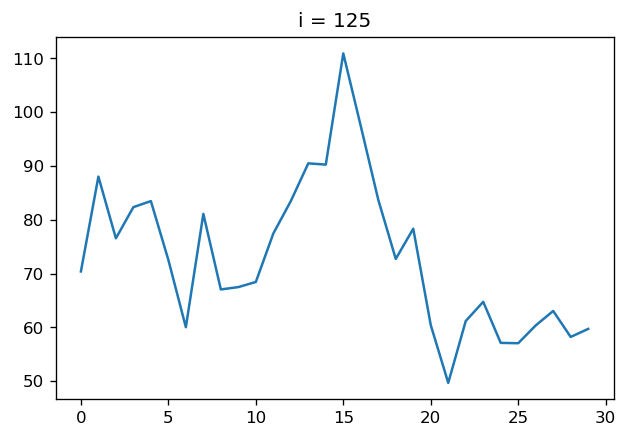

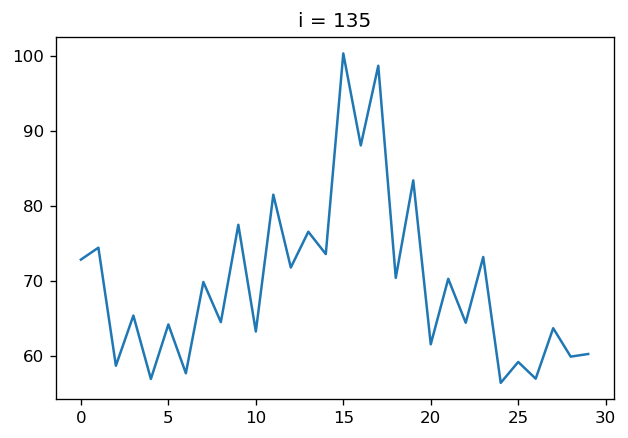

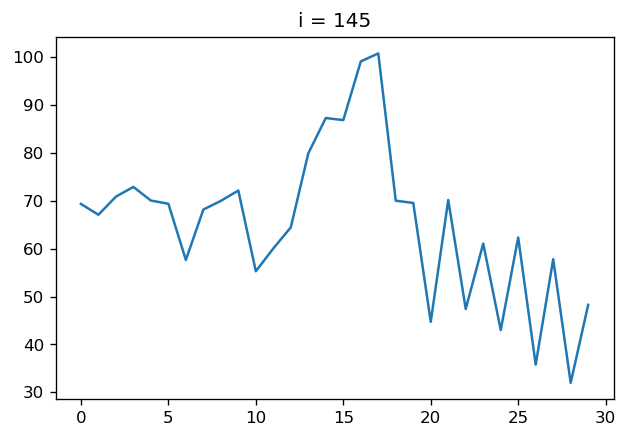

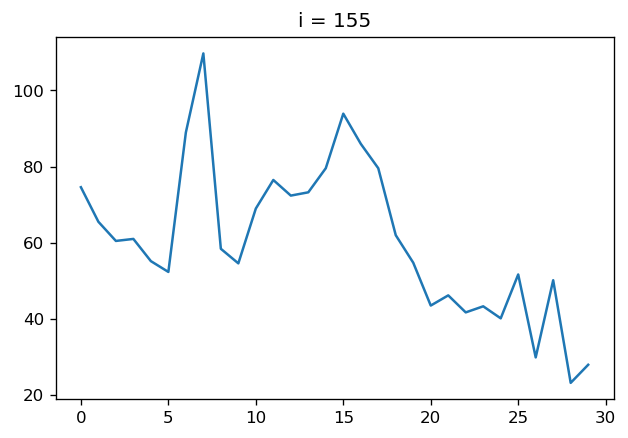

In [151]:
# for i in range(80):
#     if i%10 == 0 and i != 0:
#         print ('i = ' +str(i))
#         plt.figure()
#         plt.plot(d[i])
#         plt.title('i = ' +str(i))
        
for i in range(0, 160):
    if i%5 == 0 and i%2 !=0 and i!=5:
        print ('i = ' +str(i))
        plt.figure()
        plt.plot(d[i])
        plt.title('i = ' +str(i))

In [153]:
c = np.delete(skylines, np.s_[760:], 1)
d = np.delete(c, np.s_[:730], 1)
d = normalize(d)
#waveaxis = np.linspace(0, np.size(e, 1), np.size(e, 1))
waveaxis = waverange[730:760]*100000

upper_skyline = 160
lower_skyline = 0

sky2_a1 = []

for i in range(lower_skyline, upper_skyline):           
    if i%5 == 0 and i%10 != 0 and i!= 5:
        # create lmfit model with defined gaussian
        sky2_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky2_params = sky2_model.make_params()
        sky2_params.add('a0', value=0.5)
        sky2_params.add('a1', value=240698)
        sky2_params.add('a2', value=5)
        sky2_params.add('a3', value=0.3)
        sky2_params.add('a4', value=0)
        sky2_params.add('a5', value=0)
    
        try:
            sky2_fit_result = sky2_model.fit(d[i], sky2_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky2_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, d[i])
            plt.plot(waveaxis, sky2_fit_result.best_fit, 'r-', label='best fit')
            
        sky2_a1.append(sky2_fit_result.params['a1'].value)
sky2_a1 = np.array(sky2_a1)/100000

[[Model]]
    Model(constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2
    # data points      = 15
    # variables        = 1
    chi-square         = 5.7033e-09
    reduced chi-square = 4.0738e-10
    Akaike info crit   = -323.354117
    Bayesian info crit = -322.646067
[[Variables]]
    c:  2.40690686 +/- 5.2114e-06 (0.00%) (init = 2.406907)


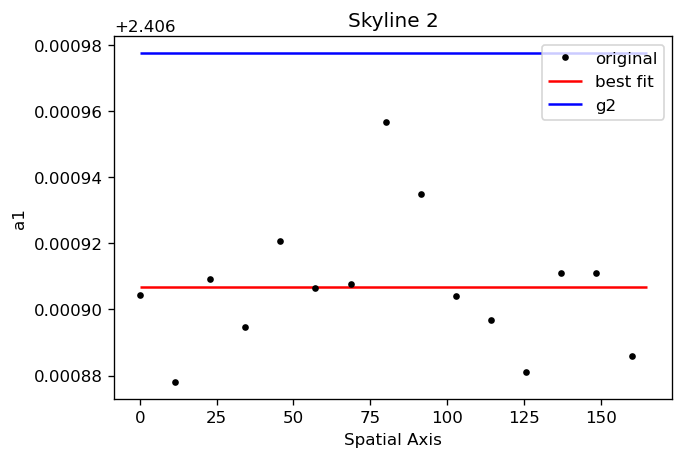

In [154]:
sky2_spat = np.linspace(lower_skyline, upper_skyline, len(sky2_a1))

x = sky2_spat
y = sky2_a1

mod = ConstantModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

sky2_spat_all = np.linspace(0, 165, 166)
# sky2_slope = out.params['slope'].value
# sky2_intercept = out.params['intercept'].value
sky2_c = out.params['c'].value
sky2_a1_best_fit = sky2_c

plt.plot(x, y, '.k', label = 'original')
plt.hlines(sky2_a1_best_fit, xmin=sky2_spat_all[0], xmax=sky2_spat_all[-1], color='r', label='best fit')
plt.hlines(g2_result.params['a1'].value, xmin=sky2_spat_all[0], xmax=sky2_spat_all[-1], color='b', label='g2')
plt.title('Skyline 2')
plt.xlabel('Spatial Axis')
plt.ylabel('a1')
plt.legend()

In [155]:
g2_result.params['a1'].value - sky2_a1_best_fit

7.079109930785421e-05

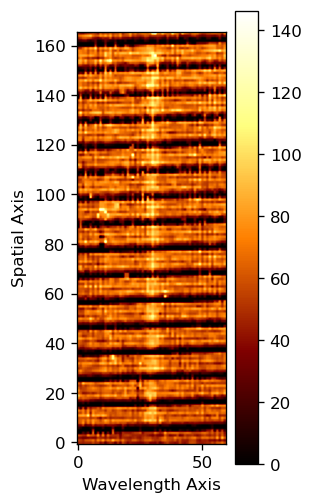

In [141]:
e = np.delete(skylines, np.s_[1000:], 1)
f = np.delete(e, np.s_[:940], 1)

plt.figure(figsize=(2,5))
# plt.imshow(c, aspect='auto', extent=[waverange[120], waverange[179], 364, 225], cmap='afmhot')
plt.imshow(f, cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()
plt.colorbar()

In [136]:
e = np.delete(skylines, np.s_[1000:], 1)
f = np.delete(e, np.s_[:940], 1)
f = normalize(f)
#waveaxis = np.linspace(0, np.size(e, 1), np.size(e, 1))
waveaxis = waverange[940:1000]*100000

upper_skyline = 160
lower_skyline = 0

sky3_a1 = []

for i in range(80):           
    if i%10 == 0 and i != 0:
        # create lmfit model with defined gaussian
        sky3_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky3_params = sky3_model.make_params()
        sky3_params.add('a0', value=0.5)
        sky3_params.add('a1', value=241433)
        sky3_params.add('a2', value=5)
        sky3_params.add('a3', value=0.3)
        sky3_params.add('a4', value=0)
        sky3_params.add('a5', value=0)
    
        try:
            sky3_fit_result = sky3_model.fit(f[i], sky3_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky3_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, f[i])
            plt.plot(waveaxis, sky3_fit_result.best_fit, 'r-', label='best fit')
            
        sky3_a1.append(sky3_fit_result.params['a1'].value)
        
for i in range(85, 160):           
    if i%5 == 0 and i%2 !=0:
        # create lmfit model with defined gaussian
        sky3_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky3_params = sky3_model.make_params()
        sky3_params.add('a0', value=0.5)
        sky3_params.add('a1', value=241433)
        sky3_params.add('a2', value=5)
        sky3_params.add('a3', value=0.3)
        sky3_params.add('a4', value=0)
        sky3_params.add('a5', value=0)
    
        try:
            sky3_fit_result = sky3_model.fit(f[i], sky3_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky3_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, f[i])
            plt.plot(waveaxis, sky3_fit_result.best_fit, 'r-', label='best fit')
            
        sky3_a1.append(sky3_fit_result.params['a1'].value)
        
sky3_a1 = np.array(sky3_a1)/100000

[[Model]]
    Model(constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2
    # data points      = 15
    # variables        = 1
    chi-square         = 5.0791e-09
    reduced chi-square = 3.6279e-10
    Akaike info crit   = -325.092845
    Bayesian info crit = -324.384795
[[Variables]]
    c:  2.41430841 +/- 4.9179e-06 (0.00%) (init = 2.414308)


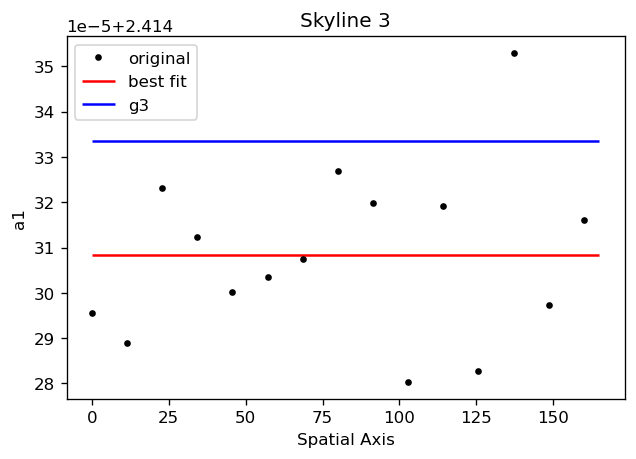

In [138]:
sky3_spat = np.linspace(lower_skyline, upper_skyline, len(sky3_a1))

x = sky3_spat
y = sky3_a1

mod = ConstantModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

sky3_spat_all = np.linspace(0, 165, 166)
# sky3_slope = out.params['slope'].value
# sky3_intercept = out.params['intercept'].value
sky3_c = out.params['c'].value
sky3_a1_best_fit = sky3_c

plt.plot(x, y, '.k', label = 'original')
plt.hlines(sky3_a1_best_fit, xmin=sky3_spat_all[0], xmax=sky3_spat_all[-1], color='r', label='best fit')
plt.hlines(g3_result.params['a1'].value, xmin=sky3_spat_all[0], xmax=sky3_spat_all[-1], color='b', label='g3')
plt.title('Skyline 3')
plt.xlabel('Spatial Axis')
plt.ylabel('a1')
plt.legend()

In [139]:
g3_result.params['a1'].value - sky3_a1_best_fit

2.498779340820434e-05